# Predict Stock Prices using Python

## Introduction
**Project Overview:**

This project focuses on predicting Microsoft stock prices using historical data and machine learning. It involves:

1. Fetching data from Yahoo Finance.
2. Engineering features for predictive modeling.
3. Using a Random Forest Classifier to predict stock price movements.
4. Evaluating the model with metrics like precision and visualizing the results.

In [1]:
#!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 31.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 124.1 MB/s eta 0:00:00
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
  Created wheel for peewee: filename=peewee-3.17.8-cp311-cp311-linux_x86_64.whl size=300774 sha256=688c748535bbb51015bcb60b65c49d24b38adc4f0b895c72562e596934d39ed5
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/6c/15/506e25bc390de450a7fa53c155cd9b0fbd13ad3e84a9abc183
Successfully built peewee


## 2. Import Libraries

In [4]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import os
print("done!")

done!


This cell loads the libraries for data fetching, manipulation, model building, evaluation, and visualization.

## 3. Download and Save Data

In [19]:
# Define the data path
DATA_PATH = "msft_data.json"

# Check if data exists; if not, download and save
if not os.path.exists(DATA_PATH):
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")
    msft_hist.to_json(DATA_PATH)
else:
    msft_hist = pd.read_json(DATA_PATH)


- Downloads Microsoft's stock data from Yahoo Finance or loads it if already saved locally. This ensures efficiency by avoiding redundant API calls.
- The saved data `(msft_data.json)` can act as a cache, reducing the dependency on continuous internet connectivity. However, the data should be periodically refreshed to reflect market updates.

## 4. Explore Data

In [20]:
# Display the first few rows
msft_hist.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.054485,0.062498,0.054485,0.059827,1031788800,0.0,0.0
1986-03-14 05:00:00,0.059827,0.063032,0.059827,0.061963,308160000,0.0,0.0
1986-03-17 05:00:00,0.061963,0.063566,0.061963,0.063032,133171200,0.0,0.0
1986-03-18 05:00:00,0.063032,0.063566,0.060895,0.061429,67766400,0.0,0.0
1986-03-19 05:00:00,0.061429,0.061963,0.059827,0.060361,47894400,0.0,0.0


- Displays the first five rows of the dataset to understand its structure and columns like Open, High, Low, Close, Volume, etc.
- The dataset includes essential metrics for analyzing price trends and patterns.

## 5. visualize closing Prices

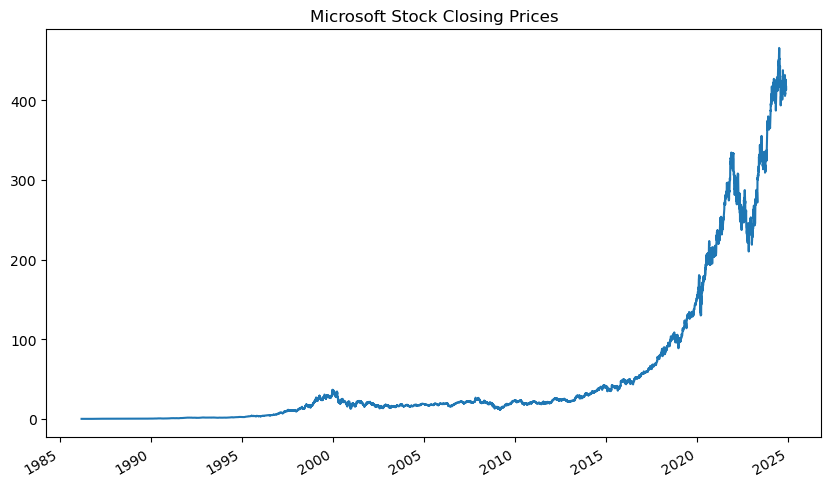

In [21]:
# Plot closing prices over time
msft_hist['Close'].plot(title="Microsoft Stock Closing Prices", figsize=(10, 6))
plt.show()


- Visualizes the historical trends in Microsoft's stock closing prices.
- This visualization helps identify long-term patterns, volatility, and potential cycles in the stock's performance.

## 6. Feature Engineering

In [22]:
# Add target column: 1 if tomorrow's price is higher, else 0
msft_hist['Target'] = (msft_hist['Close'].shift(-1) > msft_hist['Close']).astype(int)

# Add predictors from historical data
msft_hist['Open-Close'] = (msft_hist['Open'] - msft_hist['Close']) / msft_hist['Close']
msft_hist['High-Low'] = (msft_hist['High'] - msft_hist['Low']) / msft_hist['Low']


**Added Features:**

 - `Target:` Binary indicator (1 if the next day’s closing price is higher, 0 otherwise).
 - `Open-Close:` Ratio of the difference between the opening and closing prices to the closing price.
 - `High-Low:` Ratio of the day’s high to low prices.
- These features capture intraday price movements and trends, crucial for predictive models.

## 7. Train-Test Split

In [23]:
# Split data into training and test sets
train = msft_hist.iloc[:-100]
test = msft_hist.iloc[-100:]

predictors = ['Open-Close', 'High-Low', 'Close']


**Split Logic:**

- `Training:` All but the last 100 rows.
- `Testing:` Last 100 rows.
- By separating the test set from recent data, the model is evaluated on unseen, realistic scenarios, avoiding data leakage.

## 8. Build and Train model

In [24]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
model.fit(train[predictors], train['Target'])


RandomForestClassifier(min_samples_split=10, random_state=42)

- **Model:** `Random Forest Classifier` with 100 trees and a minimum sample split of 10.
- Random Forest is robust to overfitting and can handle nonlinear relationships, making it suitable for financial data.

## 9. Evaluate Model Performance

In [25]:
# Make predictions and calculate precision
preds = model.predict(test[predictors])
precision = precision_score(test['Target'], preds)

print(f"Model Precision: {precision:.2f}")


Model Precision: 0.48


- **Metric:** Precision = 0.48.
- Precision indicates that only 48% of predicted upward movements were correct. The low value suggests room for improvement, possibly by adding more predictive features or trying alternative models.

## 10. Backtesting

In [26]:
# Backtest over multiple time frames
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start, len(data), step):
        train = data.iloc[:i]
        test = data.iloc[i:(i + step)]
        model.fit(train[predictors], train['Target'])
        preds = pd.Series(model.predict(test[predictors]), index=test.index)
        combined = pd.concat({'Target': test['Target'], 'Predictions': preds}, axis=1)
        predictions.append(combined)
    return pd.concat(predictions)

backtest_results = backtest(msft_hist, model, predictors)


- **Method:**<br>
    - Iterates over the dataset in chunks, ensuring predictions use only past data.
- Backtesting simulates real-world conditions, ensuring the model isn’t overly optimistic by using future data for predictions.

## 11. Visualize the results

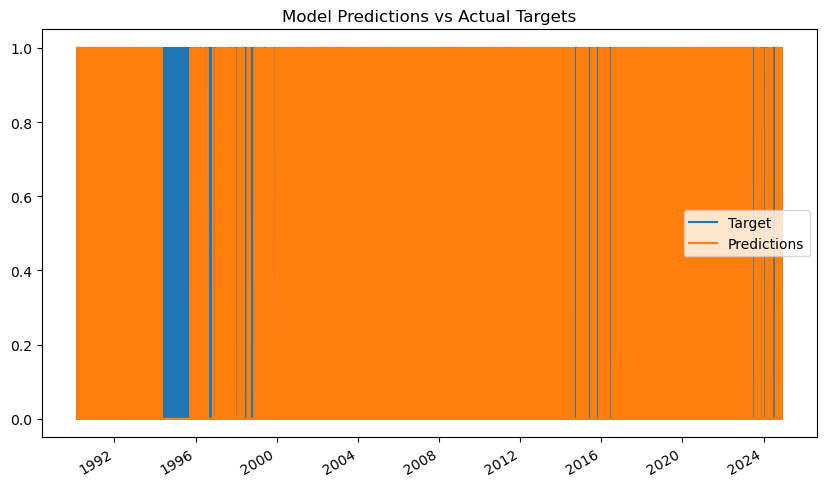

In [27]:
# Plot predictions vs actuals
backtest_results.plot(figsize=(10, 6), title="Model Predictions vs Actual Targets")
plt.show()


- Compares predictions with actual stock movements.
- Visual evaluation highlights where the model aligns or deviates from actual trends, providing actionable insights for refinement.

## 12. Conclusions:
- The project successfully integrates historical data and machine learning to predict stock movements.
- The model’s precision is modest, suggesting further feature engineering and experimentation with algorithms are needed.

**Next Steps:**

- Add features like rolling averages and trading volume trends.
- Incorporate external data like market news or economic indicators.
- Experiment with Gradient Boosting or deep learning models.
